In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, Conv2D, MaxPooling2D, Reshape, Lambda, Permute
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight

def clean_text(tweet):
    #remove emoji
    emoji = re.compile("["
                        u'\U0001F600-\U0001F64F'  # emoticons
                        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                        u'\U0001F680-\U0001F6FF'  # transport & map symbols
                        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                        u'\U00002702-\U000027B0'
                        u'\U000024C2-\U0001F251'
                        "]+", flags=re.UNICODE)
    tweet = emoji.sub(r'', tweet)

    #remove punctuation
    punctuation = '''!\(\)-\[]\{};:'"\,<>./?@#$%^&*_~=+…''' + u'\u060C' + u'\u061B' + u'\u061F'
    for c in tweet:
        if c in punctuation:
            tweet = tweet.replace(c, '')

    #remove laughter
    laughter = re.compile(r'\b(ه|خ)\1{2,}\b')
    tweet = laughter.sub('', tweet)

    #remove nonsense
    nonsense = re.compile(r'\b(.)\1{2,}\b')
    tweet = nonsense.sub(r'', tweet)

    #normalize elongated words
    repeated_characters = re.compile(r'(.)\1{2,}')
    tweet = repeated_characters.sub(r'\1', tweet)

    return tweet

def ArabicToArabizi(tweet):
    arabicLetterList = ['ض','ص','ث','ق' ,'ف' ,
                                  'غ' ,'ع' ,'ه','خ' ,'ح' ,
                                  'ج' ,'د' ,'ش' ,'س' ,'ي' ,
                                  'ن','ت' ,'ا' ,'ل','ب',
                                  'ء','ئ','ط' ,'ك','م',
                                  'ؤ','ر','لا','ى','ة',
                                  'و','ز' ,'ظ','لأ','أ' ,
                             'إ', 'آ', ' ','ذ']
    
    arabiziMappingList = [['d'],['s'],['th'],[ '2'],['f'],
                      ['8'], [ '3'], ['h'], ['5'],['7'],
                      ['j'], ['d'], ['sh'], ['s'], ['y'],
                      ['n'], ['t'], ['a'], ['l'], ['b'],
                      ['2'],['2'], ['t'], ['k'], ['m'],
                      ['o2'], ['r'], ['la'], ['a'], ['a'],
                      ['o'], ['z'], ['z'], ['la2'], ['2'],
                      ['2'],['2'], [' '], ['z']]
    arabiziSentence =''
    arabicToArabiziMapping = dict()
    for x in range(0, len(arabicLetterList)):
        arabicToArabiziMapping[arabicLetterList[x]] = arabiziMappingList[x] 
    for x in range(0, len(tweet)):
        if tweet[x] in arabicToArabiziMapping.keys():
            if tweet[x] ==  'و':
                if x == 0:
                    arabiziSentence = arabiziSentence + 'w'
                elif tweet[x-1] ==' ':
                    arabiziSentence = arabiziSentence + 'w'
                else:
                    arabiziSentence = arabiziSentence + 'o'
            else :
                arabiziSentence = arabiziSentence + arabicToArabiziMapping[tweet[x]][random.randint(0,
                                                                 len(arabicToArabiziMapping[tweet[x]])-1)]
    arabiziSentence = arabiziSentence.replace( 'alozyr', 'alwazer')
    arabiziSentence = arabiziSentence.replace( 'hza', 'hayda')
    arabiziSentence = arabiziSentence.replace( 'hzh', 'hayde')
    arabiziSentence = arabiziSentence.replace( ' lao ', ' law ')
    arabiziSentence = arabiziSentence.replace( ' ho ', ' huwe ')
    arabiziSentence = arabiziSentence.replace( 'jbran ', ' gebran ')
    arabiziSentence = arabiziSentence.replace( 'qtr ', ' qatar ')
    arabiziSentence = arabiziSentence.replace( 'wlyd ', ' walid ')
    arabiziSentence = arabiziSentence.replace( 'al7ryry ', ' al hariri ')
    return arabiziSentence

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


---

# Data Preprocessing

In [0]:
url = 'https://raw.githubusercontent.com/Hala-Mulki/L-HSAB-First-Arabic-Levantine-HateSpeech-Dataset/master/Dataset/L-HSAB'
lhsab = pd.read_csv(url, sep='\t')

newArabiziDataset = dict()
arabiziTweets = []
arabiziClasses = []
count = 0
for tweet in lhsab['Tweet']:
    newTweet = ArabicToArabizi(clean_text(tweet))
    arabiziTweets.append(newTweet)
    arabiziClasses.append(lhsab['Class'][count])
    count = count + 1

newArabiziDataset['Tweet'] = arabiziTweets
newArabiziDataset['Class'] = arabiziClasses
data = pd.DataFrame(newArabiziDataset, columns= ['Tweet', 'Class'])

---

**Data Preparation**

In [5]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 280

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True)
tokenizer.fit_on_texts(data['Tweet'].values)
VOCAB_SIZE = len(tokenizer.word_index) + 1
word_list = list(tokenizer.word_index.keys())

X = tokenizer.texts_to_sequences(data['Tweet'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

y = pd.get_dummies(data['Class'].values)
label_names = y.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4676, 280) (4676, 3)
(1170, 280) (1170, 3)


---

# CNN-LSTM

In [7]:
#Tuned
dropout_rate = 0.1
lstm_dropout = 0.7
lstm_units = 20
nb_filters = 64
filter_size = 3
L1=0.263
L2=0.15

#Not Tunable
EMBEDDING_DIM = 100
clear_session()
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(Permute((2,1), input_shape = (MAX_SEQUENCE_LENGTH, EMBEDDING_DIM)))
model.add(Lambda(lambda t: t[..., None]))
model.add(Conv2D(nb_filters, (100,filter_size), input_shape=(EMBEDDING_DIM, MAX_SEQUENCE_LENGTH, 1), name = 'Conv'))
model.add(MaxPooling2D(pool_size= model.get_layer('Conv').output_shape[1:3]))
# model.add(BatchNormalization())
model.add(Dropout(dropout_rate))
model.add(Reshape((1, nb_filters)))
model.add(LSTM(lstm_units, return_sequences=False))
# model.add(BatchNormalization())
model.add(Dropout(lstm_dropout))
model.add(Dense(3, activation='softmax', kernel_regularizer = regularizers.l1_l2(l1= L1, l2= L2)))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          2016800   
_________________________________________________________________
permute (Permute)            (None, 100, 280)          0         
_________________________________________________________________
lambda (Lambda)              (None, 100, 280, 1)       0         
_________________________________________________________________
Conv (Conv2D)                (None, 1, 278, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 1, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 64)          0         
_________________________________________________________________
reshape (Reshape)            (None, 1, 64)             0

In [0]:
e = 50
batch_size = 256

class_weights = compute_class_weight('balanced', np.unique(np.argmax(y_train, axis=1)), np.argmax(y_train, axis=1))
class_weights = dict(enumerate(class_weights))


history = model.fit(X_train, y_train, class_weight=class_weights, validation_split=0.2, verbose=1, epochs = e, batch_size = batch_size)

Epoch 1/50
15/15 [==============================] - 1s 57ms/step - loss: 5.9326 - accuracy: 0.2719 - val_loss: 5.7769 - val_accuracy: 0.4979
Epoch 2/50
15/15 [==============================] - 1s 35ms/step - loss: 5.6271 - accuracy: 0.4725 - val_loss: 5.4727 - val_accuracy: 0.5043
Epoch 3/50
15/15 [==============================] - 1s 35ms/step - loss: 5.3292 - accuracy: 0.5799 - val_loss: 5.1745 - val_accuracy: 0.5662
Epoch 4/50
15/15 [==============================] - 1s 37ms/step - loss: 5.0214 - accuracy: 0.6842 - val_loss: 4.8634 - val_accuracy: 0.7051
Epoch 5/50
15/15 [==============================] - 1s 37ms/step - loss: 4.6797 - accuracy: 0.7898 - val_loss: 4.5201 - val_accuracy: 0.7212
Epoch 6/50
15/15 [==============================] - 1s 35ms/step - loss: 4.2770 - accuracy: 0.8112 - val_loss: 4.1694 - val_accuracy: 0.7073
Epoch 7/50
15/15 [==============================] - 1s 35ms/step - loss: 3.8088 - accuracy: 0.8596 - val_loss: 3.7996 - val_accuracy: 0.7318
Epoch 8/50
15

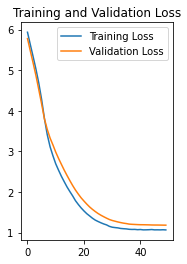

Confusion Matrix
[[226  12 108]
 [ 25  45  24]
 [ 77  28 625]]
              precision    recall  f1-score   support

     abusive       0.69      0.65      0.67       346
        hate       0.53      0.48      0.50        94
      normal       0.83      0.86      0.84       730

    accuracy                           0.77      1170
   macro avg       0.68      0.66      0.67      1170
weighted avg       0.76      0.77      0.76      1170



In [0]:
#acc = history.history['acc']
#val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(e)

#plt.figure(figsize=(8, 8))
#plt.subplot(1, 2, 1)
#plt.plot(epochs_range, acc, label='Training Accuracy')
#plt.plot(epochs_range, val_acc, label='Validation Accuracy')
#plt.legend(loc='lower right')
#plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

y_pred = np.argmax(model.predict(X_test, batch_size=1), axis=1)

print('Confusion Matrix')
print(confusion_matrix(np.argmax(y_test, axis=1), y_pred))
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=label_names))